## Importing Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Download the data

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)
train_images = mnist.train.images
test_images = mnist.test.images

## Helper Functions
Function to plot the original and the reconstructed images

In [0]:
def plot_images(original, reconstructed):
  
  fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(12,4))
  
  for images, axes in zip([original, reconstructed], axes):
    for image, ax in zip(images, axes):
      ax.imshow(image.reshape(28,28), cmap="Greys_r")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
  fig.tight_layout(pad=0.1)

## Define the placeholders

In [0]:
def get_placeholders(image_size, n_channels):
  inputs = tf.placeholder(dtype=tf.float32, shape=(None, image_size, image_size,n_channels), name='inputs')
  targets = tf.placeholder(dtype=tf.float32, shape=(None, image_size, image_size,n_channels), name='targets')
  return inputs, targets

## Define the model

In [0]:
def encoder_decoder_network(X):
  
  
  W1 = tf.get_variable("W1", shape=[3,3,1,32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
  relu1 = tf.nn.relu(conv1)
  pool1 = tf.nn.max_pool(relu1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
  
  
  W2 = tf.get_variable("W2", shape=[3,3,32,32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv2 = tf.nn.conv2d(pool1, W2, strides=[1,1,1,1], padding='SAME')
  relu2 = tf.nn.relu(conv2)
  pool2 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
  
  W3 = tf.get_variable("W3", shape=[3,3,32,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv3 = tf.nn.conv2d(pool2, W3, strides=[1,1,1,1], padding='SAME')
  relu3 = tf.nn.relu(conv3)
  pool3 = tf.nn.max_pool(relu3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
  encoded = pool3
  
  
  upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
  #7*7*8
  W4 = tf.get_variable("W4", shape=[3,3,16,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv4 = tf.nn.conv2d(upsample1, W4, strides=[1,1,1,1], padding='SAME')
  relu4 = tf.nn.relu(conv4)
  
  upsample2 = tf.image.resize_nearest_neighbor(relu4, (14,14))
  # 14*14*8
  W5 = tf.get_variable("W5", shape=[3,3,16,32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv5 = tf.nn.conv2d(upsample2, W5, strides=[1,1,1,1], padding='SAME')
  relu5 = tf.nn.relu(conv5)
  
  # 28*28*8
  upsample3 = tf.image.resize_nearest_neighbor(relu5, (28,28))
  
  W6 = tf.get_variable("W6", shape=[3,3,32,32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv6 = tf.nn.conv2d(upsample3, W6, strides=[1,1,1,1], padding='SAME')
  relu6 = tf.nn.relu(conv6)
  
  W7 = tf.get_variable("W7", shape=[3,3,32,1], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv7 = tf.nn.conv2d(relu6, W7, strides=[1,1,1,1], padding='SAME')
  
  logits = conv7
  
  decoded = tf.nn.sigmoid(logits)
  
  return encoded, decoded, logits

## Define the training operations

In [0]:
def get_train_operations(logits, targets, learning_rate):
  loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets))
  training_op = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(loss)
  return loss, training_op

## Train the model and plot reconstructed images

In [0]:
def train_model(epochs, batch_size, image_size, n_channels, learning_rate, noise_factor):
  tf.reset_default_graph()
  inputs,targets = get_placeholders(image_size, n_channels)
  encoded, decoded, logits = encoder_decoder_network(inputs)
  loss, training_op = get_train_operations(logits, targets, learning_rate)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
      epoch_loss = 0
      for batch in range(mnist.train.num_examples//batch_size):
        data = mnist.train.next_batch(batch_size)[0]
        data = data.reshape(-1,image_size,image_size,n_channels)
        noisy_images = noise_factor * np.random.randn(*data.shape) + data
        batch_loss, _ = sess.run([loss, training_op], feed_dict = {inputs:noisy_images, targets:data})
        epoch_loss += batch_loss
      print("Epoch: {}/{},  Loss: {:.3f}".format(epoch+1, epochs, epoch_loss))
    print("Training over\n")
    print("Reconstructing test images from encoded images")


    test_images = mnist.test.images[:10]
    test_images = test_images.reshape(-1,image_size,image_size,n_channels)
    noisy_test_images = test_images + noise_factor *np.random.randn(*test_images.shape)
    reconstructed = sess.run(decoded, feed_dict = {inputs:noisy_test_images})
    plot_images(noisy_test_images, reconstructed)

## Define the model parameters

In [0]:
epochs = 50
batch_size = 200
learning_rate = 0.001
n_channels =1
noise_factor = 0.5 
image_size = 28

## Run the model

W0623 05:53:41.891494 140225355773824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 1/50,  Loss: 67.170
Epoch: 2/50,  Loss: 45.659
Epoch: 3/50,  Loss: 40.792
Epoch: 4/50,  Loss: 38.596
Epoch: 5/50,  Loss: 37.282
Epoch: 6/50,  Loss: 36.432
Epoch: 7/50,  Loss: 35.664
Epoch: 8/50,  Loss: 35.093
Epoch: 9/50,  Loss: 34.613
Epoch: 10/50,  Loss: 34.282
Epoch: 11/50,  Loss: 33.954
Epoch: 12/50,  Loss: 33.663
Epoch: 13/50,  Loss: 33.425
Epoch: 14/50,  Loss: 33.194
Epoch: 15/50,  Loss: 33.025
Epoch: 16/50,  Loss: 32.827
Epoch: 17/50,  Loss: 32.635
Epoch: 18/50,  Loss: 32.498
Epoch: 19/50,  Loss: 32.380
Epoch: 20/50,  Loss: 32.229
Epoch: 21/50,  Loss: 32.191
Epoch: 22/50,  Loss: 32.003
Epoch: 23/50,  Loss: 31.924
Epoch: 24/50,  Loss: 31.833
Epoch: 25/50,  Loss: 31.769
Epoch: 26/50,  Loss: 31.651
Epoch: 27/50,  Loss: 31.582
Epoch: 28/50,  Loss: 31.515
Epoch: 29/50,  Loss: 31.425
Epoch: 30/50,  Loss: 31.383
Epoch: 31/50,  Loss: 31.344
Epoch: 32/50,  Loss: 31.221
Epoch: 33/50,  Loss: 31.187
Epoch: 34/50,  Loss: 31.170
Epoch: 35/50,  Loss: 31.107
Epoch: 36/50,  Loss: 31.066
E

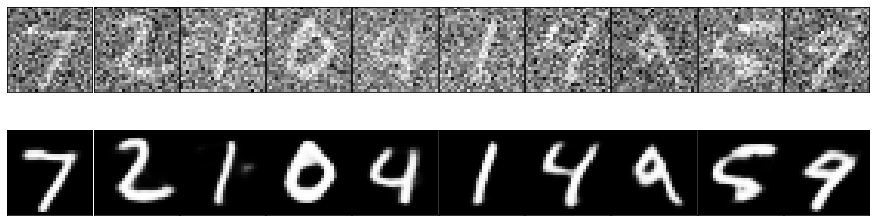

In [9]:
train_model(epochs = epochs,
           batch_size=batch_size,
           learning_rate=learning_rate,
           n_channels = n_channels,
            
           noise_factor = noise_factor,
           image_size=image_size)